# Encoding experiment using FastSRM

We train the model on a train session learning how to transfer data between subjects' space and shared space.
On a test session we use all subjects but one to compute the shared response and use this shared response to predict data from the test subject. We use R2 score as a measure of performance.

# Real fMRI data

Next, we'll download a publicly available fMRI dataset and run SRM on these data. This dataset comprises fMRI data for 20 subjects listening to the spoken story Pie Man by Jim O'Grady (archived on the Princeton DataSpace). Note that we use 20 subjects to minimize computational demands for this tutorial and recommend larger sample sizes for publication. The gzipped data archive file is ~1.5 GB in size, and may take a couple minutes to download and unzip. The functional data were acquired with 3 x 3 x 4 mm voxels and 1.5 s TRs. Data were preprocessed using fMRIPrep (Esteban et al., 2018), including spatial normalization to MNI space (the T1-weighted ICBM 2009c Nonlinear Asymmetric template). The data were then smoothed to 6 mm FWHM using AFNI's 3dBlurToFWHM (Cox, 1996). The following confound variables were regressed out using 3dTproject: six head motion parameters (and their first derivatives), framewise displacement, six prinicipal components from an anatomical mask of cerebrospinal fluid (CSF) and white matter, sine/cosine bases for high-pass filtering (cutoff: 0.00714 Hz; 140 s), as well as a linear and quadratic trends. The anatomical template and a brain mask (i.e., excluding skull) are supplied as well. These have been resampled to match resolution of the functional images.

In [1]:
from urllib.request import urlretrieve
from time import time
from glob import glob
from os.path import join
import nibabel
from nilearn.image import new_img_like
from nilearn.input_data import NiftiMasker, MultiNiftiMasker
import numpy as np
from joblib import Parallel, delayed
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt

In [2]:
# Download data tarball from Princeton DataSpace
t0 = time()
urlretrieve('https://dataspace.princeton.edu/jspui/bitstream/'
            '88435/dsp01dz010s83s/6/pieman-isc-tutorial.tgz',
            'data_fastsrm.tgz');
!tar -xzf data_fastsrm.tgz
print("Done in %.2f seconds" % (time() - t0))

Done in 643.28 seconds


# Step 1: Mask and save the data
- We split our data into two sessions (in order to be able to perform our encoding experiment)
- We mask the data and save them into .npy file

In [3]:
t0 = time()
# the directory where our data are located
data_dir = 'pieman-isc-tutorial'
# Filenames for MRI data; gzipped NIfTI images (.nii.gz)
func_fns = glob(join(data_dir, ('sub-*_task-pieman_space-MNI152NLin2009cAsym'
                                '_desc-tproject_bold.nii.gz')))
# The mask for our data
mask_fn = join(data_dir, 'MNI152NLin2009cAsym_desc-brain_mask.nii.gz')

# Let us mask these data and separate them into two sessions
def separate_and_mask(func):
    # Load data
    N = nibabel.load(func).get_data()
    # Separate them into two sessions
    N_1 = N[:, :, :, :250]
    N_2 = N[:, :, :, 250:]
    I_1 = new_img_like(func, N_1)
    I_2 = new_img_like(func, N_2)
    # Mask data
    masker = NiftiMasker(
        mask_img=mask_fn, 
        detrend=True,
        standardize=True,
        smoothing_fwhm=6
    ).fit()
    X_1 = masker.transform(I_1)
    X_2 = masker.transform(I_2)
    # Save data
    np.save(func[:-7] + "_session_1", X_1)
    np.save(func[:-7] + "_session_2", X_2)

# I have 4 cores in my computer, it you have more increase n_jobs
Parallel(n_jobs=4, verbose=10)(
    delayed(separate_and_mask)(
        func
    ) for func in func_fns)
print("Done in %.2f seconds" % (time() - t0))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   24.7s
[Parallel(n_jobs=4)]: Done  16 out of  20 | elapsed:   32.7s remaining:    8.2s


Done in 40.33 seconds


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   40.3s finished


# Step 2: mask and save an atlas
- Atlases are used in FastSRM to make computation faster
- Any off-the-shelf big atlas should work (number of regions of the atlas should be larger than number of components used in SRM) we use Basc 444 for our example

In [4]:
def load_atlas(atlas, mask_img):
    # Load masker
    atlas_masker = MultiNiftiMasker(
        mask_img=mask_img).fit()
    X = nibabel.load(atlas).get_data()
    # If the atlas is a deterministic atlas
    # (each region is identified by a number starting from 1)
    if len(X.shape) == 3:
        n_components = len(np.unique(X)) - 1
        xa, ya, za = X.shape
        A = np.zeros((xa, ya, za, n_components + 1))
        for c in np.unique(X)[1:].astype(int):
            X_ = np.copy(X)
            X_[X_ != c] = 0.
            X_[X_ == c] = 1.
            A[:, :, :, c] = X_
        A = atlas_masker.transform(new_img_like(atlas, A))
        A = np.argmax(A, axis=0)
    # If the atlas is a probabilistic atlas
    # (each region is assigned to a component)
    else:
        A = atlas_masker.transform(atlas)
    return A

t0 = time()
from nilearn.datasets import fetch_atlas_basc_multiscale_2015
atlas = fetch_atlas_basc_multiscale_2015(data_dir=data_dir)['scale444']
print(atlas)
A = load_atlas(atlas, mask_fn)
np.save(atlas[:-7], A)
atlas_path = atlas[:-7] + ".npy"
print("Done in %.2f" % (time() - t0))


Dataset created in pieman-isc-tutorial/basc_multiscale_2015



Downloaded 193985 of 193985 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)
Extracting data from pieman-isc-tutorial/basc_multiscale_2015/3cbcf0eeb3f666f55070aba1db9a758f/1861819..... done.


pieman-isc-tutorial/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale444.nii.gz
Done in 26.51


### Note about input data

- ProbSRM takes as input input images: a list of n_subjects np array of size (n_voxels, n_timeframes)
- FastSRM takes as input (1) input images: a matrix of npy files of size (number of subjects, number of sessions) each file should be loadable with np.load and represents a matrix of size (n_timeframes, n_voxels) (2) an atlas: np array of shape (n_components, n_voxels) in case of probabilistic atlas and simply (n_voxels) for a deterministic atlas

# Step 3: Fit of the model
- Load data
- Train model on first session

In [5]:
subjects = [18, 19, 20, 21, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42]
sessions = [1, 2]

files = np.array([
    [glob(join(data_dir, "sub-%.3i*_session_%i*" %(sub, sess)))[0] 
     for sess in sessions]
    for sub in subjects])

# 20 subjects x 2 sessions file matrix
print("Input shape")
print(files.shape)

Input shape
(20, 2)


In [6]:
def load_and_concat(paths):
    """
    Take list of path and yields input data for ProbSRM
    Parameters
    ----------
    paths
    Returns
    -------
    X
    """
    X = []
    for i in range(len(paths)):
        X_i = np.concatenate([np.load(paths[i, j])
                              for j in range(len(paths[i]))], axis=0).T
        X.append(X_i)
    return X

In [7]:
from brainiak.funcalign.fastsrm import FastSRM
from brainiak.funcalign.srm import SRM
# We specify
# temp_dir: a temporary directory used to store spatial maps (this saves memory when number of subjects is big)
#   (not really needed here but I'll use it anyway)
# n_jobs: the number of cores to use
# low_ram: in case you still have memory issues even when temp_dir is not None set this to True
# n_iter: can easily be set to 100 with no difference in fitting time 
#   but we set it to 10 to be fair with ProbSRM

fastsrm = FastSRM(
    atlas=np.load(atlas_path),
    n_components=20,
    n_jobs=4,
    n_iter=10,
    temp_dir=data_dir,
    low_ram=False
)
probsrm = SRM(
    n_iter=10,
    features=20
)

print("Fitting FastSRM")
t0 = time()
fastsrm.fit(files[:, :1])
print("Done in %.2f" % (time() - t0))

print("Fitting ProbSRM")
train_files = load_and_concat(files[:, :1])
t0 = time()
probsrm.fit(train_files)
print("Done in %.2f" % (time() - t0))

Fitting FastSRM
Done in 5.49
Fitting ProbSRM
Done in 38.92


# Step 4: Use the model to reconstruct data from a leftout subjects using others

In [8]:
from sklearn.model_selection import KFold
# List where we record test R2 scores per voxels of all subjects
var_e_fastsrm = []
var_e_probsrm = []
for subjects_train, subjects_test in KFold(n_splits=5,
                                    shuffle=True
                                   ).split(np.arange(len(subjects))):
    shared_response_fastsrm = fastsrm.transform(
        files[subjects_train, :][:, 1:],
        subjects_indexes=subjects_train
    )

    shared_response_probsrm = np.mean(
            [load_and_concat(files[subjects_train, :][:, 1:])[i].T.dot(
                probsrm.w_[subjects_train[i]]
            ) for i in range(len(subjects_train))], axis=0)
    
    # In ProbSRM sessions are concatenated
    Y_pred_probsrm = np.array([shared_response_probsrm.dot(probsrm.w_[s_test].T)
             for s_test in subjects_test])

    # The reconstructed data with FastSRM is a matrix of size (n_test_subjects, n_test_sessions)
    Y_pred_fastsrm = fastsrm.inverse_transform(
                shared_response_fastsrm,
                subjects_indexes=subjects_test
            )
    # Let us make fastSRM match the shape of ProbSRM
    Y_pred_fastsrm = Y_pred_fastsrm[:, 0, :, :]

    # This is the true data we are trying to reconstruct
    Y_true = np.array([np.load(file) for file in files[subjects_test, :][:, 1]])
    
    
    for i in range(len(subjects_test)):
        var_e = 1 - (Y_pred_fastsrm[i] - Y_true[i]).var(axis=0)
        var_e_fastsrm.append(var_e)

    
    for i in range(len(subjects_test)):
        var_e = 1 - (Y_pred_probsrm[i] - Y_true[i]).var(axis=0)
        var_e_probsrm.append(var_e)

# Step 5: Plot results

R2 score FastSRM: 0.088
R2 score ProbSRM: 0.081


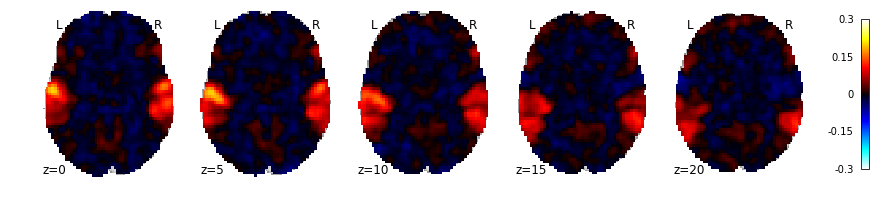

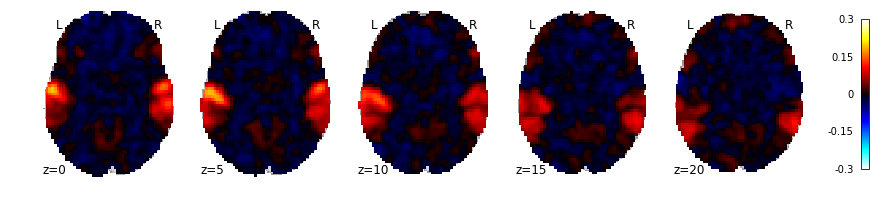

In [9]:
# Average test R2 scores
var_e_fast = np.mean(var_e_fastsrm, axis=0)
var_e_prob = np.mean(var_e_probsrm, axis=0)

masker = NiftiMasker(
        mask_img=mask_fn).fit()

plot_stat_map(
    masker.inverse_transform(var_e_fast),
    display_mode="z",
    cut_coords=[0, 5, 10, 15, 20],
    vmax=0.3
)

plot_stat_map(
    masker.inverse_transform(var_e_prob),
    display_mode="z",
    cut_coords=[0, 5, 10, 15, 20],
    vmax=0.3
)

# R2 score in a ROI given by areas where ProbSRM performs the best
print("R2 score FastSRM: %.3f" % np.mean(var_e_fast[var_e_prob > 0.05]))
print("R2 score ProbSRM: %.3f" % np.mean(var_e_prob[var_e_prob > 0.05]))